# Some explorative simulations

**Mengqi Liu**

**Jun 12, 2023**
___

In [9]:
import numpy as np
import pandas as pd
import math
from itertools import permutations, combinations
import statsmodels.formula.api as smf
import multiprocessing as mp
from tqdm import tqdm
import matplotlib.pyplot as plt

## 1 Continuous Z

$N=100, Z\sim \textrm{Unif}([0,10))$

### 1.1 H0

$X|Z \sim \textrm{Bernoulli}(\frac{e^{\sin(\theta Z)}}{4})$, $Y|Z \sim \textrm{Bernoulli}(\frac{e^{\sin(\theta Z)}}{4})$, $X \perp \!\!\! \perp Y|Z$.

Here $\theta=1$ with varying $M$ (number of bins).


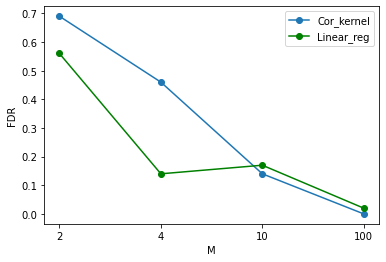

In [30]:
result1 = pd.read_csv("result1.csv", index_col=0)
plt.plot(result1.loc['Cor_kernel'], '-o', result1.loc['Linear_reg'], 'g-o')
plt.xlabel("M")
plt.ylabel("FDR")
plt.legend(['Cor_kernel', 'Linear_reg'])
plt.show()

$M=10$ with varying $\theta \in \{0.01, 0.1, 0.5, 1, 10, 50\}$.

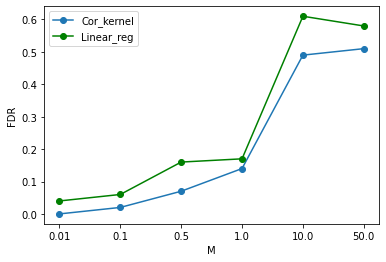

In [21]:
result3 = pd.read_csv("result3.csv", index_col=0)
plt.plot(result3.loc['Cor_kernel'], '-o', result3.loc['Linear_reg'], 'g-o')
plt.xlabel("M")
plt.ylabel("FDR")
plt.legend(['Cor_kernel', 'Linear_reg'])
plt.show()

### 1.2 H1

Let $f(z)=\frac{e^{\sin(z)}}{4}$,
$$\begin{aligned}
p_{XY|Z}(X = 1; Y = 1|Z=z) &= f(z)^2 + f(z)/5\\
p_{XY|Z}(X = 0; Y = 0|Z=z) &= (1-f(z))^2  + f(z)/5 \\
p_{XY|Z}(X = 1; Y = 0|Z=z) &= p_{XY|Z}(X = 0; Y = 1|Z=z) = 4f(z)/5 +f(z)^2.
\end{aligned}
$$

Here $X \not \! \perp \!\!\! \perp Y |Z$.

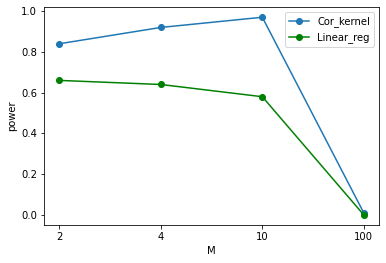

In [22]:
result2 = pd.read_csv("result2.csv", index_col=0)
plt.plot(result2.loc['Cor_kernel'], '-o', result2.loc['Linear_reg'], 'g-o')
plt.xlabel("M")
plt.ylabel("power")
plt.legend(['Cor_kernel', 'Linear_reg'])
plt.show()

## 2 Discrete Z

$N=100, Z\sim \textrm{Unif}({0,1,...,9})$

### 2.1 H0

$X|Z \sim \textrm{Bernoulli}(\frac{e^{\sin(\theta Z)}}{4})$, $Y|Z \sim \textrm{Bernoulli}(\frac{e^{\sin(\theta Z)}}{4})$, $X \perp \!\!\! \perp Y|Z$.

Here $\theta=1$ with varying $M$ (number of bins).

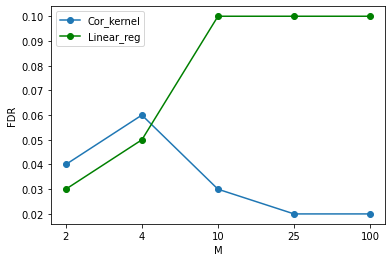

In [31]:
result6= pd.read_csv("result6.csv", index_col=0)
plt.plot(result6.loc['Cor_kernel'], '-o', result6.loc['Linear_reg'], 'g-o')
plt.xlabel("M")
plt.ylabel("FDR")
plt.legend(['Cor_kernel', 'Linear_reg'])
plt.show()

$M=10$ with varying $\theta \in \{0.01, 0.1, 0.5, 1, 10, 50\}$.

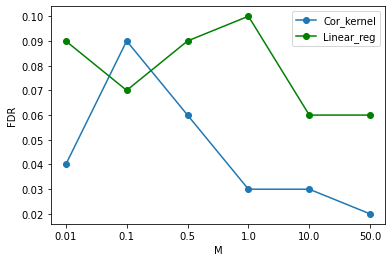

In [32]:
result4= pd.read_csv("result4.csv", index_col=0)
plt.plot(result4.loc['Cor_kernel'], '-o', result4.loc['Linear_reg'], 'g-o')
plt.xlabel("M")
plt.ylabel("FDR")
plt.legend(['Cor_kernel', 'Linear_reg'])
plt.show()

### 2.2 H1

Let $f(z)=\frac{e^{\sin(z)}}{4}$,
$$\begin{aligned}
p_{XY|Z}(X = 1; Y = 1|Z=z) &= f(z)^2 + f(z)/5\\
p_{XY|Z}(X = 0; Y = 0|Z=z) &= (1-f(z))^2  + f(z)/5 \\
p_{XY|Z}(X = 1; Y = 0|Z=z) &= p_{XY|Z}(X = 0; Y = 1|Z=z) = 4f(z)/5 +f(z)^2.
\end{aligned}
$$

Here $X \not \! \perp \!\!\! \perp Y |Z$.

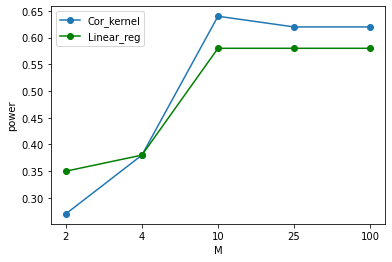

In [33]:
result5= pd.read_csv("result5.csv", index_col=0)
plt.plot(result5.loc['Cor_kernel'], '-o', result5.loc['Linear_reg'], 'g-o')
plt.xlabel("M")
plt.ylabel("power")
plt.legend(['Cor_kernel', 'Linear_reg'])
plt.show()

In [5]:
def data_generative1(N=100, s=1):
    np.random.seed(s); Z = np.random.uniform(0, 10, N)

    def fz(Z):
        return np.array([np.exp(math.sin(z) - np.log(4)) for z in Z])
    
    np.random.seed(s); X = np.random.binomial(1, fz(Z))
    np.random.seed(s); Y = np.random.binomial(1, fz(Z))
    return X, Y, Z

In [67]:
X, Y, Z = data_generative1(N=100)

In [46]:
def compute_G(Z, M = 10):
    bins = np.linspace(np.min(Z), np.max(Z), M+1)
    bins[0] -= 1 # pd.cut doesn't include left boundary value except add right=False
    G = np.array(pd.cut(Z, bins, labels=[x for x in range(M)]))
    return G

def compute_T(X, Y, Z, G, M=10, l1=2, l2=2, cont=True):
    
    def phi(x, y, x_im, y_im, y_jm):
        return int(all([x_im == x, y_im == y])) - int(all([x_im == x, y_jm == y]))

    def kernel(ind):
        assert len(ind) == 4 
        perm = permutations(ind)
        h = 0
        for temp_ind in list(perm):
            for x in range(l1):
                for y in range(l2):
                    h += phi(x, y, X[temp_ind[0]], Y[temp_ind[0]], Y[temp_ind[1]]) * phi(x, y, X[temp_ind[2]], Y[temp_ind[2]], Y[temp_ind[3]])
        h /= math.factorial(4)
        if h != 0:
            print(h)
        return h
    
    def weighted_kernel(ind, w1, w2):
        assert len(ind) == 4 
        perm = permutations(ind)
        h = 0
        for temp_ind in list(perm):
            for x in range(l1):
                for y in range(l2):
                    a = 1
                    if len(w1) > 0:
                        a *= 1 + len(np.where(np.array(w1) == x)[0])
                    if len(w2) > 0:
                        a *= 1 + len(np.where(np.array(w2) == y)[0])
                    h += phi(x, y, X[temp_ind[0]], Y[temp_ind[0]], Y[temp_ind[1]]) \
                         * phi(x, y, X[temp_ind[2]], Y[temp_ind[3]], Y[temp_ind[3]]) / a
        h /= math.factorial(4)
        if h != 0:
            print(h)
        return h
    
    if cont:
        T = 0
        for m in range(M):
            m_ind = list(np.where(G == m)[0])
            if len(m_ind) >= 4:
                n = len(m_ind)
                U = 0
                comb = combinations(m_ind, 4)
                for ind in list(comb):
                    if all([ind[0] < ind[1], ind[1] < ind[2], ind[2] < ind[3]]):
                        U += kernel(ind)
                U /= math.comb(n, 4)
                print("U", U)
                T += n * U
    else:
        T = 0
        for m in range(M):
            m_ind = list(np.where(G == m)[0])
            if len(m_ind) >= 4:
                tm = int((len(m_ind) - 4)/4)
                t1 = np.min([tm, l1])
                t2 = np.min([tm, l2])
                w = np.random.choice(m_ind, t1+t2)
                w1 = w[0:t1]
                w2 = w[t1:(t1+t2)]
                n = len(m_ind)
                m_ind = list(set(m_ind) - set(w1) - set(w2))
                U = 0
                comb = combinations(m_ind, 4)
                for ind in list(comb):
                    U += weighted_kernel(ind, w1, w2)
                U /= math.comb(2 * tm + 4, 2)
                wm = np.sqrt(np.min([n, l1]) * np.min([n, l2]))
                T += n * U * wm
    return T
        

def compute_T_linear(X, Y, Z):
    mod = smf.ols(formula='Y ~ X + Z', data=pd.DataFrame({'X':X, 'Y':Y, 'Z':Z})).fit()
    T = mod.params['X']
    return T

def LPT(X, Y, Z, G, B=100, M=10, l1=2, l2=2, alpha=0.05):
    T_sam = compute_T(X, Y, Z, G, M, l1, l2)
    print("T_sam", T_sam)
    T_per = np.zeros(B)

    T_sam_linear = compute_T_linear(X, Y, Z)
    #print("T_sam_linear", T_sam_linear)
    T_per_linear = np.zeros(B)

    def perm_Y(Y, s):
        new_Y = Y.copy()
        for m in range(M):
            m_ind = list(np.where(G == m)[0])
            m_ind_new = m_ind.copy()
            np.random.seed(s); np.random.shuffle(m_ind_new)
            new_Y[m_ind] = new_Y[m_ind_new]
        #print("permutation", all([new_Y[i]==Y[i] for i in range(len(Y))]))
        return new_Y

    for b in range(B):
        new_Y = perm_Y(Y, b)
        T_per[b] = compute_T(X, new_Y, Z, G, M, l1, l2)
        print("T_per[b]", T_per[b])
        T_per_linear[b] = compute_T_linear(X, new_Y, Z)
        #print("T_per_linear[b]", T_per_linear[b])
    p = (T_per >= T_sam).sum() / B
    p_linear = (T_per_linear >= T_sam_linear).sum() / B
    return int(p <= alpha), int(p_linear <= alpha)
    




In [ ]:
result1 = np.zeros(100)
for i in range(100):
    print(i)
    X, Y, Z = data_generative1(N=100, s=i)
    G = compute_G(Z, M=10)
    result1[i] = LPT(X, Y, Z, G, B = 10, M = 10, l1 = 2, l2 = 2, alpha = 0.05)   

In [25]:
def data_generative2(N=100, s=1):
    np.random.seed(s); Z = np.random.uniform(0, 10, N)

    def fz(Z):
        return np.array([np.exp(math.sin(z) - np.log(4)) for z in Z])
    
    X = np.zeros(N)
    Y = np.zeros(N)
    fZ = fz(Z)
    for i in range(N):
        z = fZ[i]
        prob = [z**2 + z/5, (1-z)**2 + z/5, 4*z/5 - z**2, 0]
        prob[3] = 1 - np.sum(prob)
        assert all([x>=0 for x in prob])
        np.random.seed(s)
        situ = np.random.multinomial(1, prob) @ [1, 2, 3, 4]
        if situ == 1:
            X[i] = 1
            Y[i] = 1
        if situ == 2:
            X[i] = 0
            Y[i] = 0
        if situ == 3:
            X[i] = 1
            Y[i] = 0
        if situ == 4:
            X[i] = 0
            Y[i] = 1
            

    return X, Y, Z

In [ ]:
result3 = np.zeros([2, 100])
for i in tqdm(range(100)):
    X, Y, Z = data_generative2(N=100, s=i)
    G = compute_G(Z, M=10)
    result3[:, i] = LPT(X, Y, Z, G, B = 40, M = 10, l1 = 2, l2 = 2, alpha = 0.05) 